# Project-Title - Help_Naviagte_Robots

#  Introduction

We are given IMU(Inertial Measurement Units) data that is collected by a robot while moving on different types of floor surface. We are going to train our machine learing model on the data and test our data and hopefully be able to correctly predict the type of floor surface.

**A.Importing the Packages**

In [1]:
# Importing libraries and packages:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


**B.Loading the Data**

In [2]:
# reading a CSV file directly from Web (or local drive), and store it in a pandas DataFrame:
X_train = pd.read_csv("https://raw.githubusercontent.com/lkampat/project_4661/main/X_train.csv")
Y_train = pd.read_csv("https://raw.githubusercontent.com/lkampat/project_4661/main/y_train.csv")

**C.Data Exploration**

In [3]:
X_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


There are 3810 series of input data. Each series contains 128 sets of measurements,thereby each measurements were taken 128 times during the course of a walk, So total 487680  values of data.

In [23]:
#check the shape of the DataFrame (rows, columns):
X_train.shape,Y_train.shape

((2667, 19), (3810, 4))

In [5]:
Y_train

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
...,...,...,...
3805,3805,55,tiled
3806,3806,67,wood
3807,3807,48,fine_concrete
3808,3808,54,tiled


**D.Plotting the Y_train graph**

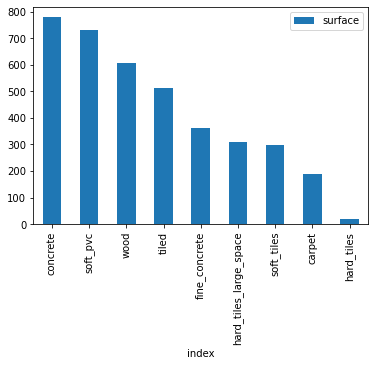

In [6]:
Y_train['surface'].value_counts().reset_index().plot(x='index',y='surface',kind='bar')

This is a multi-class classification problem. It's supervised and has imbalanced classes. Each measurement has 128 data points taken over time for each sensor. The identifier for each measurement is series_id. Then each measurement is repeated on the same surface multiple times which is identified by group_id. Each group_id is a unique recording session and has only one surface type

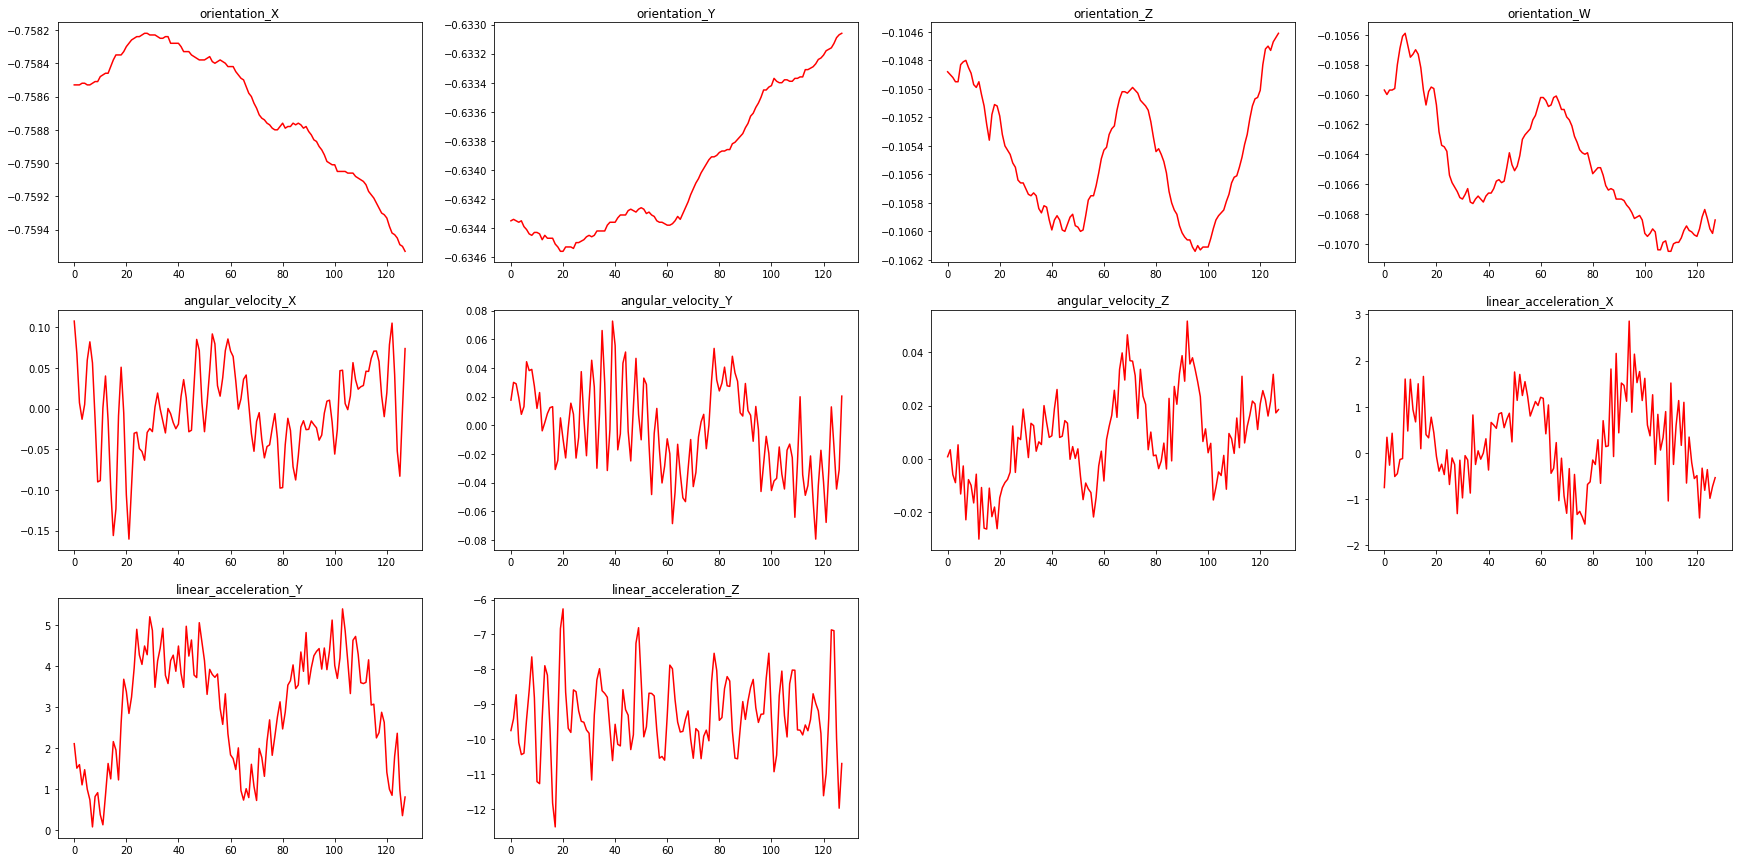

In [7]:
def plot_series(series):
    df_train=X_train[X_train['series_id']==series]
    
    plt.figure(figsize=(30,15))
    for i,col in enumerate(df_train.columns[3:]):
        plt.subplot(3,4,i+1)
        df_train[col].plot(color='red')
        plt.title(col)

plot_series(0)

Orientation X increases , Orientation Y decreases and Strong correlation between angular velocity Z and angular velocity Y


**E.Preprocessing of Data**

we are converting the 4-degree orientation value into 3-degree euler angle value for better understanding. New values: roll, pitch and yaw, and add them to corresponding row.

**Converting the Quaternions to Roll,Pitch,Yaw**

In [8]:
#Function to convert quaternion to euler angles
def quaternion_to_euler(x, y, z, w):
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(sinr_cosp, cosr_cosp)
    
    sinp = 2.0 * (w * y - z * x)
    if sinp > 1.0:
        sinp = 1.0
    if sinp < -1.0:
        sinp = -1.0
    pitch = math.asin(sinp)
    
    siny_cosp = 2.0 * (w * z + x * y)
    cosy_cosp = 1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(siny_cosp, cosy_cosp)
    
    return roll, pitch, yaw

(x, y, z, w) -> (x,y,z) quaternions to euler angles

In [9]:
#function to add euler features to each row
def add_euler_features(dataframe):
    x, y, z, w = dataframe["orientation_X"].tolist(), dataframe["orientation_Y"].tolist(), dataframe["orientation_Z"].tolist(), dataframe["orientation_W"].tolist()
    rolls, pitches, yaws = [], [], []
    for i in range(len(x)):
        roll, pitch, yaw = quaternion_to_euler(x[i], y[i], z[i], w[i])
        rolls.append(roll)
        pitches.append(pitch)
        yaws.append(yaw)
    dataframe["roll"] = rolls
    dataframe["pitch"] = pitches
    dataframe["yaw"] = yaws

In [10]:
import math
add_euler_features(X_train)

**F. Feature Engineering**

we are grouping all of our input data by their series_id and took the mean and sum of each attributes within each series and stored the output into a new dataframe. The returned dataframe will be our new sample data for our machine learning model.

In [11]:
def feature_engineering(dataframe):
    ret_dataframe = pd.DataFrame()
    
    for column in dataframe.columns:
        if column == "row_id" or column == "measurement_number":
            continue
        ret_dataframe[column + "_mean"] = dataframe.groupby(["series_id"])[column].mean()
        ret_dataframe[column + "_sum"] = dataframe.groupby(["series_id"])[column].sum()

    return ret_dataframe

In [12]:
X_train = feature_engineering(X_train)
X_train

,series_id_mean,series_id_sum,orientation_X_mean,orientation_X_sum,orientation_Y_mean,orientation_Y_sum,orientation_Z_mean,orientation_Z_sum,orientation_W_mean,orientation_W_sum,...,linear_acceleration_Y_mean,linear_acceleration_Y_sum,linear_acceleration_Z_mean,linear_acceleration_Z_sum,roll_mean,roll_sum,pitch_mean,pitch_sum,yaw_mean,yaw_sum
series_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,-0.758666,-97.10922,-0.634008,-81.15298,-0.105474,-13.500690,-0.106470,-13.628110,...,2.984195,381.976947,-9.320391,-1193.010000,2.841734,363.741973,-0.025037,-3.204732,1.396035,178.692530
1,1,128,-0.958606,-122.70162,0.241867,30.95897,0.031650,4.051239,-0.146876,-18.800070,...,2.768193,354.328696,-9.388899,-1201.779100,2.840129,363.536528,-0.010369,-1.327174,-0.492731,-63.069540
2,2,256,-0.512057,-65.54334,-0.846171,-108.30988,-0.129371,-16.559440,-0.071082,-9.098478,...,2.886745,369.503305,-9.395783,-1202.660200,2.845529,364.227651,-0.012195,-1.560956,2.055021,263.042744
3,3,384,-0.939169,-120.21364,0.310140,39.69794,0.038955,4.986241,-0.142319,-18.216810,...,2.657922,340.214058,-9.451164,-1209.749000,2.845777,364.259493,-0.015107,-1.933725,-0.635656,-81.363929
4,4,512,-0.891301,-114.08647,0.428144,54.80246,0.060056,7.687225,-0.136460,-17.466930,...,2.981498,381.631730,-9.349988,-1196.798500,2.842442,363.832589,-0.009793,-1.253551,-0.894147,-114.450875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,3805,487040,-0.228787,-29.28475,0.961730,123.10148,0.144690,18.520330,-0.042361,-5.422159,...,2.745177,351.382690,-9.465299,-1211.558256,2.839285,363.428462,-0.015273,-1.954967,-2.672166,-342.037278
3806,3806,487168,0.542262,69.40952,0.826590,105.80358,0.129890,16.625920,0.076335,9.770885,...,2.900305,371.239000,-9.367247,-1199.007600,2.839466,363.451624,-0.014674,-1.878226,1.982632,253.776906
3807,3807,487296,-0.416511,-53.31344,0.895374,114.60787,0.140185,17.943660,-0.070016,-8.962046,...,3.660786,468.580635,-9.192466,-1176.635710,2.826992,361.854985,-0.008638,-1.105621,-2.269413,-290.484806


**G.Transform "surface" data from categorical data to numerical data.**

Converting all our Surface classification in numerical data in Encoded surface column in Y_train Data. It is required so that the classifier gets discrete integers from 0 to 9 in order to classify properly

In [13]:
lableDict = {"concrete": 0, "soft_pvc": 1, "wood": 2, "tiled": 3, "fine_concrete": 4, 
             "hard_tiles_large_space": 5, "soft_tiles": 6, "carpet": 7, "hard_tiles": 8}
def encodeSurface(y_dataframe):
    surface = y_dataframe["surface"].tolist()
    encodedSurface = []
    for i in range(len(surface)):
        encodedSurface.append(lableDict[surface[i]])
    y_dataframe["encoded_surface"] = encodedSurface

encodeSurface(Y_train)
Y_train.head()

,series_id,group_id,surface,encoded_surface
0,0,13,fine_concrete,4
1,1,31,concrete,0
2,2,20,concrete,0
3,3,31,concrete,0
4,4,22,soft_tiles,6


**H. Merge the data**

The "series_id" is the primary key in y_train, and it's also the foreign key to y_train in X_train.
Its easier for training that each example in X to have a y label therefore we merge the X dataframe and y dataframe accordingly using the primary key series_id.

In [14]:
X_train['encoded_surface']=Y_train['encoded_surface']
X_train['group_id']=Y_train['group_id']
X_train['surface']=Y_train['surface']

X_train.head()

,series_id_mean,series_id_sum,orientation_X_mean,orientation_X_sum,orientation_Y_mean,orientation_Y_sum,orientation_Z_mean,orientation_Z_sum,orientation_W_mean,orientation_W_sum,...,linear_acceleration_Z_sum,roll_mean,roll_sum,pitch_mean,pitch_sum,yaw_mean,yaw_sum,encoded_surface,group_id,surface
series_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,-0.758666,-97.10922,-0.634008,-81.15298,-0.105474,-13.500690,-0.106470,-13.628110,...,-1193.0100,2.841734,363.741973,-0.025037,-3.204732,1.396035,178.692530,4,13,fine_concrete
1,1,128,-0.958606,-122.70162,0.241867,30.95897,0.031650,4.051239,-0.146876,-18.800070,...,-1201.7791,2.840129,363.536528,-0.010369,-1.327174,-0.492731,-63.069540,0,31,concrete
2,2,256,-0.512057,-65.54334,-0.846171,-108.30988,-0.129371,-16.559440,-0.071082,-9.098478,...,-1202.6602,2.845529,364.227651,-0.012195,-1.560956,2.055021,263.042744,0,20,concrete
3,3,384,-0.939169,-120.21364,0.310140,39.69794,0.038955,4.986241,-0.142319,-18.216810,...,-1209.7490,2.845777,364.259493,-0.015107,-1.933725,-0.635656,-81.363929,0,31,concrete
4,4,512,-0.891301,-114.08647,0.428144,54.80246,0.060056,7.687225,-0.136460,-17.466930,...,-1196.7985,2.842442,363.832589,-0.009793,-1.253551,-0.894147,-114.450875,6,22,soft_tiles


**I. Fitting and Predicting the data**

**Function to Predict ROC_AUC score using LabelBinarizer for multiclass for each classifier**

In [15]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test, y_predict_classifier, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_predict_classifier)
    return roc_auc_score(y_test, y_pred, average=average)

**Function to fit and Predict the model**

In [16]:
def my_classifer(classifier,X_train,y_train,X_test,y_test,class_names):
    
    newdict = {}
    #fit the model
    classifier.fit(X_train, y_train)
    
    #Predict the model
    y_predict_label = classifier.predict(X_test)
    
    #performed various performance metric for this model:
    #get accuracy_score for the model
    accuracy = accuracy_score(y_test, y_predict_label)
    print('\n Accuracy:', accuracy)
    
    #get Auc score for the model
    roc_auc_score=multiclass_roc_auc_score(y_test, y_predict_label)
    print("\n AUC Score_LableBinarizer:",roc_auc_score)
    
    #get cross-validation score for the model
    accuracy_list = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
    accuracy_cv = accuracy_list.mean()
    print('\n Accuracy_cv-',accuracy_cv)
    
    return y_predict_label
   

**Feature Matrix and label data**

In [17]:
## create a python list of feature names that would like to pick from the dataset:
feature_cols=['series_id_mean','angular_velocity_X_mean',
 'angular_velocity_X_sum',
 'angular_velocity_Y_mean',
 'angular_velocity_Y_sum',
 'angular_velocity_Z_mean',
 'angular_velocity_Z_sum',
 'linear_acceleration_X_mean',
 'linear_acceleration_X_sum',
 'linear_acceleration_Y_mean',
 'linear_acceleration_Y_sum',
 'linear_acceleration_Z_mean',
 'linear_acceleration_Z_sum',
 'roll_mean',
 'roll_sum',
 'pitch_mean',
 'pitch_sum',
 'yaw_mean',
 'yaw_sum']

# use the above list to select the features from the  DataFrame
X = X_train[feature_cols] 
# select a Series of labels (the last column) from the DataFrame
Y=X_train['encoded_surface']
Y_target=X_train['surface']


#preprocessing the data
from sklearn import preprocessing
X = preprocessing.scale(X)
X

array([[-1.73159626, -0.25587618, -0.25587618, ..., -2.88260064,
         0.93406707,  0.93406707],
       [-1.73068705,  0.42616418,  0.42616418, ...,  0.96072623,
        -0.1195804 , -0.1195804 ],
       [-1.72977783,  0.23758238,  0.23758238, ...,  0.48217882,
         1.30168218,  1.30168218],
       ...,
       [ 1.72977783,  3.04766361,  3.04766361, ...,  1.41424033,
        -1.11070163, -1.11070163],
       [ 1.73068705,  0.09149122,  0.09149122, ...,  0.55458747,
        -1.29401951, -1.29401951],
       [ 1.73159626, -0.40161816, -0.40161816, ..., -1.11597043,
        -0.8325505 , -0.8325505 ]])

**J.Splitting the Dataset:**

In [18]:
from sklearn.model_selection import train_test_split

# Randomly splitting the original dataset into training set and testing set:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=3)

**1.K-Nearest Neighbors Classifier**


 KNN CLASSIFIER 

------------------

 Accuracy: 0.531058617672791

 AUC Score_LableBinarizer: 0.6978665134349957

 Accuracy_cv- 0.5530183727034121

 Confusion Matrix


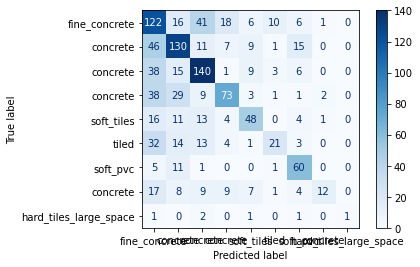


 KNN Classifier Tpr: [0.55454545 0.59360731 0.66037736 0.46794872 0.49484536 0.23863636
 0.76923077 0.17910448 0.16666667]

 KNN Classifier Fpr: [0.20910076 0.11255411 0.10633727 0.04356636 0.03441683 0.01611374
 0.03755869 0.00371747 0.        ]
Overall Accuracy of the class: [0.74540682 0.83114611 0.8503937  0.88976378 0.9256343  0.92650919
 0.94925634 0.94838145 0.99562555]


In [19]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from statistics import mean
print('\n KNN CLASSIFIER \n')
print("------------------")
class_names=Y_target
k = 10
my_knn = KNeighborsClassifier(n_neighbors=k)
y_predict_label=my_classifer(my_knn,X_train,y_train,X_test,y_test,class_names)
# Build the confusion matrix of our 3-class classification problem
cnf_matrix = confusion_matrix(y_test, y_predict_label)
print('\n Confusion Matrix')
#plot Confusion matric for the given classifier
disp = plot_confusion_matrix(my_knn, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()
#calculating TPR and FPR based on plotted confusion matrix
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR1 = TP/(TP+FN)
print("\n KNN Classifier Tpr:",TPR1)
# Specificity or true negative rate
FPR1 = FP/(TN+FP)
print("\n KNN Classifier Fpr:",FPR1)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy of the class:",ACC)


    


KNN calculates the distance between the train data and test data by picking the nearest K data points. Since a lot of the data from different class could be very close to each other which is hard for KNN to identify the accurate target for the corresponding features. Therefore, this model did not produce high accuracy compared to other ML models. Implemented confusion matrix to find the sensitivity and specificity for all the classes/labels.


**2 . Decision tree Classifier**


 DECISION TREE CLASSIFIER 

________________________________

 Accuracy: 0.7392825896762905

 AUC Score_LableBinarizer: 0.8351003385575478

 Accuracy_cv- 0.7191601049868767

 Decision tree Confusion Matrix


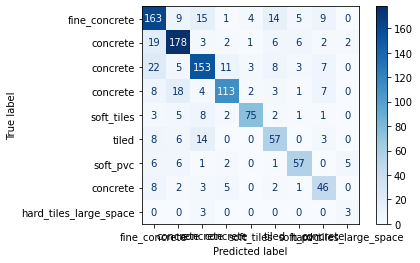


 Decision tree Tpr: [0.74090909 0.81278539 0.72169811 0.72435897 0.77319588 0.64772727
 0.73076923 0.68656716 0.5       ]

 Decision tree Fpr: [0.17659805 0.19264069 0.16433942 0.11448835 0.07170172 0.05402844
 0.05352113 0.04275093 0.00263852]
Overall Accuracy of the class from confusion matrix: 0.9420627977058423


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from statistics import mean

print('\n DECISION TREE CLASSIFIER \n')
print("________________________________")

class_names=Y_target
my_dt=DecisionTreeClassifier(random_state=3)
y_predict_label=my_classifer(my_dt,X_train,y_train,X_test,y_test,class_names)

# Build the confusion matrix of our 3-class classification problem
cnf_matrix = confusion_matrix(y_test, y_predict_label)

 
print('\n Decision tree Confusion Matrix')    
    
#plot Confusion matric for the given classifier
disp = plot_confusion_matrix(my_dt, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()
    
    
#calculating TPR and TNR based on plotted confusion matrix
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR2 = TP/(TP+FN)
print("\n Decision tree Tpr:",TPR2)
# Specificity or true negative rate
FPR2 = TP/(TN+FP)
print("\n Decision tree Fpr:",FPR2)

# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy of the class from confusion matrix:",mean(ACC))


    

Decision tree classifier uses divide and conquer algorithm which splits the training data on feature that has the highest information gain till it is sufficient enough to identify the different classes recursively producing higher accuracy compared to KNN classifier. We implemented confusion matrix to find the sensitivity and specificity for all the classes/labels.


**3.Random Forest Classifier**


 RANDOM FOREST 

_______________________

 Accuracy: 0.7830271216097988

 AUC Score_LableBinarizer: 0.8415442816157404

 Accuracy_cv- 0.7742782152230971

 Random Forest Confusion Matrix 



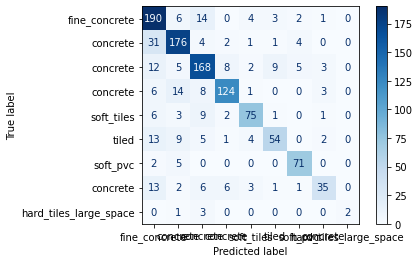


 Random forest Tpr :  [0.86363636 0.80365297 0.79245283 0.79487179 0.77319588 0.61363636
 0.91025641 0.52238806 0.33333333]

 Random forest Fpr: [0.08992416 0.0487013  0.05263158 0.01925025 0.01434034 0.01421801
 0.01126761 0.00929368 0.        ]
Overall Accuracy of the class from confusion matrix: 0.9517838048021775


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from statistics import mean

print('\n RANDOM FOREST \n')
print("_______________________")

class_names=Y_target
my_RandomForest = RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=3)
y_predict_label=my_classifer(my_RandomForest,X_train,y_train,X_test,y_test,class_names)


print('\n Random Forest Confusion Matrix \n')
# Build the confusion matrix of our 3-class classification problem

cnf_matrix = confusion_matrix(y_test, y_predict_label)

#plot Confusion matric for the given classifier
disp = plot_confusion_matrix(my_RandomForest, X_test, y_test,display_labels=class_names,cmap=plt.cm.Blues)
plt.show()
    
    
#calculating TPR and TNR based on plotted confusion matrix
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR3 = TP/(TP+FN)
print("\n Random forest Tpr : ",TPR3)
# Specificity or true negative rate
FPR3 = FP/(TN+FP)
print("\n Random forest Fpr:",FPR3)

# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy of the class from confusion matrix:", mean(ACC))




Random Forest Classifier contains a random collection of decision tree classifier where it merges all decision tree for better accuracy. The default value we used for amount of decision tree is 100, so more the trees, better the accuracy when compared to the above ML classifiers. We implemented confusion matrix to find the sensitivity and specificity for all the classes/labels.


**K.Plot Roc Curve of all classifiers**

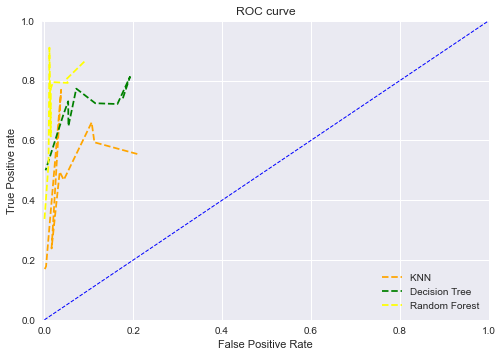

In [22]:
# Importing the "pyplot" package of "matplotlib" library of python to generate 
# graphs and plot curves:
import matplotlib.pyplot as plt

# The following line will tell Jupyter Notebook to keep the figures inside the explorer page 
# rather than openng a new figure window:
%matplotlib inline

plt.style.use('seaborn')

 
# plot roc curves
plt.plot(FPR1, TPR1, linestyle='--',color='orange', label='KNN ')
plt.plot(FPR2, TPR2, linestyle='--',color='green', label='Decision Tree')
plt.plot(FPR3, TPR3, linestyle='--',color='Yellow', label='Random Forest')
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.0])

plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

**From the graph above, it depicts that the "Random forest" curve is almost nearer to the upper corner when compared with KNN and decsion tree, thus resulting as the best model for this particular project with the accuracy of 0.78**